In [1]:
%load_ext autoreload
%autoreload 2

# Introduction

In this notebook, we show an example of using faim via the Fairlearn like API (contribution to [Fairlearn](https://fairlearn.org) in progress), using it to reproduce the results in the paper.

Note that the Fairlearn API version of the code has been updated to work significantly more robustly and performantly, compared to the original research paper code.  To reproduce the exact results presented in our [research paper](https://arxiv.org/abs/2212.00469), please use the [original research code](../README.md#recreate-experimental-results-from-paper)

# Synthetic Dataset
This dataset from the paper represents a hypothetical scoring situation (i.e. credit worthiness).

In [2]:
import pandas as pd

synthetic_data_from_paper = pd.read_csv(
    "https://raw.githubusercontent.com/MilkaLichtblau/faim/main/data/synthetic/2groups/2022-01-12/dataset.csv"
)
synthetic_data_from_paper.columns 

Index(['group', 'uuid', 'true_score', 'pred_score', 'groundTruthLabel',
       'predictedLabel'],
      dtype='object')

In [3]:
len(synthetic_data_from_paper)

100000

In [4]:
y_scores=synthetic_data_from_paper.pred_score
y_scores = (y_scores - y_scores.min())/(y_scores.max() - y_scores.min())
y_ground_truth=synthetic_data_from_paper.groundTruthLabel.astype(bool)
sensitive_features=synthetic_data_from_paper.group

# Unfairness
In this dataset, one group is advantages compared to the other (see Figure 1 in [paper](https://arxiv.org/abs/2212.00469) for more details)

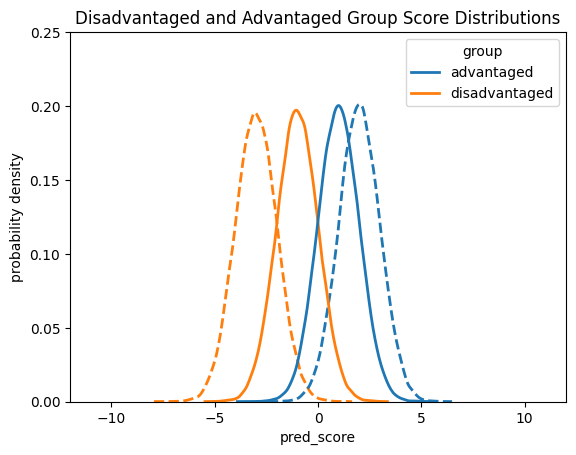

In [5]:
from copy import deepcopy
import seaborn as sns
import matplotlib.pyplot as plt

sns.color_palette("tab10")

plot_data = deepcopy(synthetic_data_from_paper)
group_names=["advantaged", "disadvantaged"]
plot_data["group"] = plot_data.group.map(lambda idx: group_names[idx])

fig, ax = plt.subplots()
sns.kdeplot(data=plot_data, x="pred_score", hue="group", linestyle="--", linewidth=2, ax=ax)
sns.kdeplot(data=plot_data, x="true_score", hue="group", linestyle="-", linewidth=2, ax=ax)
_ = ax.set_ylabel("probability density")
_ = ax.set_xlim([-12, 12])
_ = ax.set_ylim([0, 0.25])
_ = ax.set_title("Disadvantaged and Advantaged Group Score Distributions")

We will use FAIM to remove some of this unfairnless

# Unfairness Mitigation with FAIM
In FAIM, the user chooses how to balance between otherwise mutually exclusive fairness criteria. 
FAIM currently supports three fairness criteria:

1. Calibration between groups (scores actually correspond to probability of positive)
1. Balance for the negative class (average score of truly negative individuals equal across groups)
1. Balance for the positive class (average score of truly positive individuals equal across groups)

which are encoded via a parameter $\theta$.

In the following sections, $\theta$ is varied to demonstrate the effectiveness of FAIM (see Figure 2 in the [paper](https://arxiv.org/abs/2212.00469) for more details).

In [27]:
from faim.fairlearn_api import FAIM
from typing import Any

synthetic_data_from_paper["normalized_pred_score"] = y_scores

def faim_and_plot(thetas: list[float] | dict[Any, list[float]], fair_data_col_name: str, score_discretization_step: float = 0.02) -> FAIM:
    faim = FAIM(thetas=thetas, score_discretization_step=score_discretization_step)

    faim.fit(
        y_scores=y_scores, 
        y_ground_truth=y_ground_truth, 
        sensitive_features=sensitive_features
    )
    synthetic_data_from_paper[fair_data_col_name] = faim.predict(
        y_scores=y_scores, sensitive_features=sensitive_features
    )

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 5), sharex=True)
    sns.histplot(
        data=synthetic_data_from_paper, x=fair_data_col_name, hue="group", bins=faim.discrete_score_bins,
        ax=ax1
    )
    sns.histplot(
        data=synthetic_data_from_paper, x="normalized_pred_score", hue="group", bins=faim.discrete_score_bins,
        ax=ax2
    )
    ax1.set_title(fair_data_col_name)
    ax2.set_title("raw")
    ax2.set_xlabel("score")

    return faim

## No Mitigation
In the future, FAIM should allow partial or no mitigation by setting thetas that add to less than 1, such as `[0,0,0]` for no mitigation, and `[1/2, 0, 0]` for partial calibration.

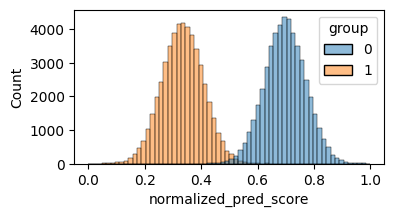

In [28]:
plt.figure(figsize=(4, 2))
ax = sns.histplot(data=synthetic_data_from_paper, x="normalized_pred_score", hue="group")

# Calibration

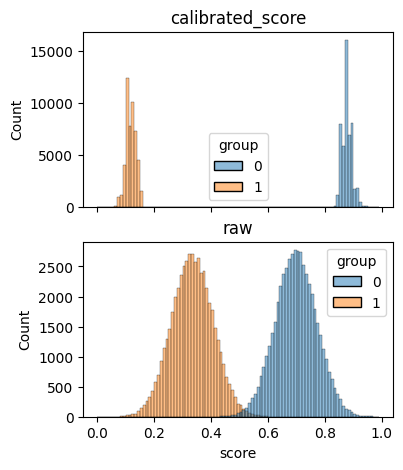

In [35]:
thetas = [1, 0, 0]
faim_calibrated = faim_and_plot(thetas=thetas, fair_data_col_name="calibrated_score", score_discretization_step=0.01)

## Balance of Negative Class

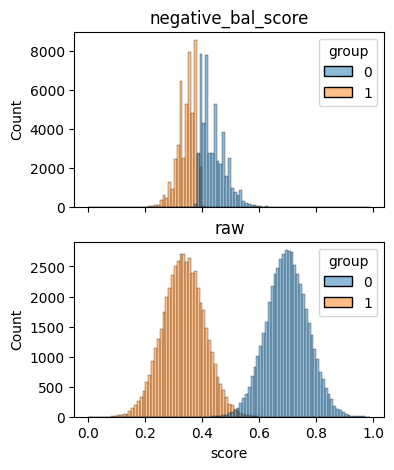

In [34]:
thetas = [0, 1, 0]
faim_negative_bal = faim_and_plot(thetas=thetas, fair_data_col_name="negative_bal_score", score_discretization_step=0.01)

## Balance of the Positive Class

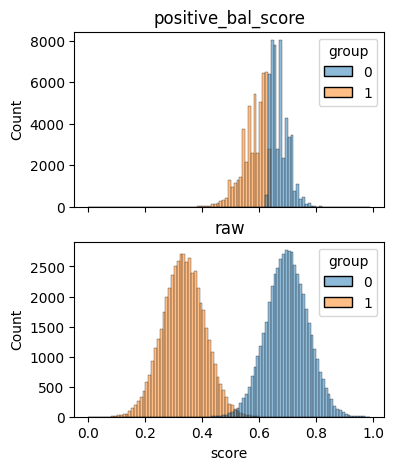

In [33]:
thetas = [0, 0, 1]
faim_positive_bal = faim_and_plot(thetas=thetas, fair_data_col_name="positive_bal_score", score_discretization_step=0.01)

## Mixture of Multiple Fairness Criteria
Fairness scores represent distribution that is interpelated between each of the three pure fairness criteria above.

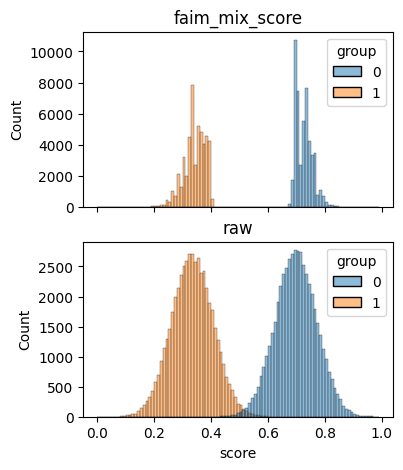

In [36]:
thetas = [1/3, 1/6, 1/2]
faim_mix = faim_and_plot(thetas=thetas, fair_data_col_name="faim_mix_score", score_discretization_step=0.01)